# AT&T Spam Detector Project

## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, GRU, SimpleRNN, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from wordcloud import WordCloud

import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorboard.plugins.hparams import api as hp
import warnings
warnings.filterwarnings("ignore")

2024-07-29 17:53:59.344045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## IMPORT DATA

In [2]:
df = pd.read_csv('spam.csv', encoding='latin1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## EXPLORE DATA

In [3]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


Il y a trois colonnes inutiles que nous devrions supprimer.

In [4]:
"""
Dans ce block de code, nous travaillons avec un DataFrame 'df' qui contient des messages de spam potentiels.

Les colonnes 'Unnamed: 2', 'Unnamed: 3' et 'Unnamed: 4' contiennent des segments de texte supplémentaires pour certains mails qui ont été divisés entre plusieurs colonnes. 

Premièrement, pour chaque colonne non nommée 'Unnamed: 2', 'Unnamed: 3', et 'Unnamed: 4', on remplace les valeurs manquantes par des chaînes de caractères vides "". C'est pour éviter les erreurs lors de la concaténation de ces colonnes.

Ensuite, on concatène les données de ces colonnes non-nommées avec la colonne 'v2' qui contient la majorité du contenu des mails. L'idée est de rassembler tout le texte en une seule colonne. 

On utilise `ignore_index=True` pour ne pas garder l'indexation d'origine, car après la concaténation, l'ordre des mails n'a plus d'importance.

Enfin, notre DataFrame est réduit pour conserver uniquement 'v1' (qui contient les labels indiquant si le mail est un spam ou non) et 'v2' (qui contient maintenant le contenu complet des mails).

La dernière ligne affiche les cinq premières rangées de df pour vérifier si le traitement a été effectué correctement.
"""

df['Unnamed: 2'] = df['Unnamed: 2'].fillna("")
df['Unnamed: 3'] = df['Unnamed: 3'].fillna("")
df['Unnamed: 4'] = df['Unnamed: 4'].fillna("")
df['v2']=pd.concat([df['v2'],df['Unnamed: 2'],df['Unnamed: 3'],df['Unnamed: 4']], ignore_index=True)

df = df[['v1','v2']]

df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Jetons un coup d'œil à certaines lignes pour en connaître le contenu

In [5]:
df['v2'][100]

'Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx'

In [6]:
df['v2'][55]

'Do you know what Mallika Sherawat did yesterday? Find out now @  &lt;URL&gt;'

In [7]:
df['v2'][412]

"Okies... I'll go yan jiu too... We can skip ard oso, go cine den go mrt one, blah blah blah... "

Voyons maintenant la répartition des spams et des hams dans notre première colonne

In [8]:
# Nous recherchons à quoi ressemble les spams
df.loc[df['v1'] == 'spam', :]

,v1,v2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [9]:
df['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

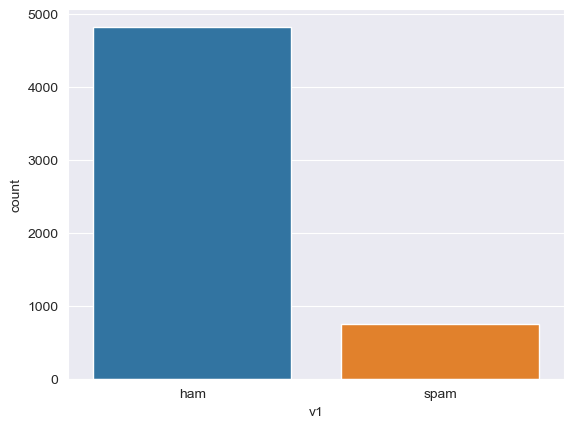

In [10]:
sns.countplot(data=df,x='v1')
plt.show()

In [11]:
# Comptez le nombre de fois qu'un spam (représenté par '1') apparaît dans la colonne 'v1'
spam_count = df.v1.value_counts()[1]

# Obtenez le nombre total de messages dans la colonne 'v1'
total_messages = len(df.v1)

# Calculez le pourcentage de spams parmi tous les messages
spam_percentage = (spam_count / total_messages) * 100

# Arrondissez le pourcentage à deux chiffres après la virgule
spam_percentage = round(spam_percentage, 2)

# Affichez le pourcentage de spams dans le DataFrame
print("Le pourcentage de spams dans nos données est {}%".format(spam_percentage))

Le pourcentage de spams dans nos données est 13.41%


L'ensemble de données est déséquilibré, mais reste un échantillon suffisamment important pour obtenir des résultats intéressants.

## PREPROCESSING

### Spacy

In [12]:
# Utilisation de la bibliothèque Spacy :
nlp = spacy.load('en_core_web_sm')

In [13]:
df.rename(columns={"v1": "Target", "v2": "Text"}, inplace=True)

In [14]:
# Supprimer tous les caractères non alphanumériques sauf les espaces :
df["text_clean"] = df["Text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# Supprimer les doubles espaces et les espaces en début et fin de chaîne :
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# Suppression des mots vides (stop words) et remplacement de chaque mot par leur lemme :
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [15]:
# Labellisation de la colonne target
df['Target_value'] = df['Target'].map({'ham':0,'spam':1})

In [16]:
df.head()

,Target,Text,text_clean,Target_value
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0


### WordCloud

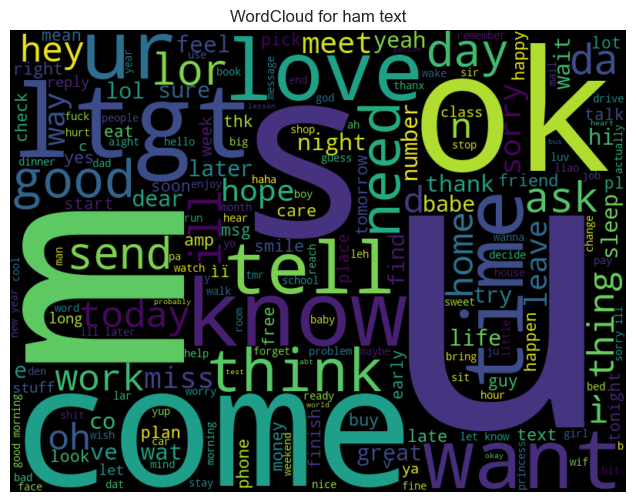

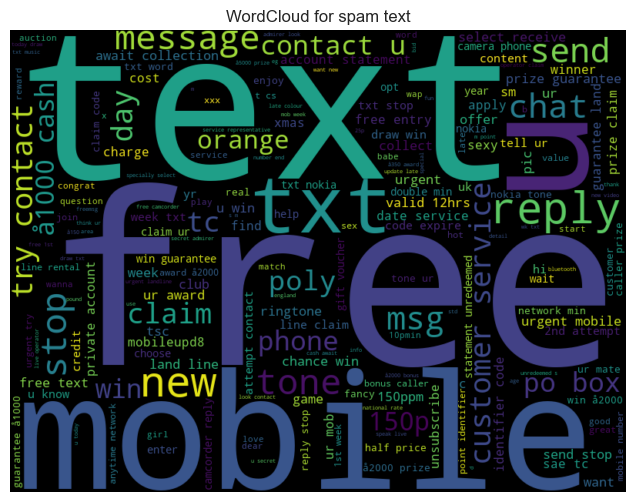

In [17]:
# Générer et afficher des nuages de mots pour chaque catégorie cible
for target in df['Target'].unique():
    words = ' '.join(df[df['Target'] == target]['text_clean'])
    wordcloud = WordCloud(width=800, height=600).generate(words)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for {target} text")
    plt.axis('off')
    plt.show()

➡️ Les résultats de Wordcloud ne sont pas surprenants avec des mots-clés typiques tels que « FREE », « MOBILE», « REPLY », « CHAT » ou « SEND » qui incitent à se faire piéger.

### Tokenization

In [18]:
# Tokeniser à l'aide du Tokenizer de TensorFlow
max_words = 3000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="out_of_vocab")
tokenizer.fit_on_texts(df['text_clean'])
df["text_tokenized"] = tokenizer.texts_to_sequences(df['text_clean'])

df.head()

,Target,Text,text_clean,Target_value,text_tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0,"[1, 230, 446, 462, 941, 36, 52, 204, 942, 79, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0,"[10, 195, 463, 289, 2, 1452]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1,"[13, 299, 4, 532, 663, 34, 1453, 850, 422, 145..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0,"[2, 125, 150, 2353, 2, 85]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0,"[708, 23, 664, 129]"


### Padding

In [19]:
# Appliquer le padding au texte tokenisé :
text_padded = tf.keras.preprocessing.sequence.pad_sequences(df["text_tokenized"], padding="post")

text_padded

array([[   1,  230,  446, ...,    0,    0,    0],
       [  10,  195,  463, ...,    0,    0,    0],
       [  13,  299,    4, ...,    0,    0,    0],
       ...,
       [   1,  936,    1, ...,    0,    0,    0],
       [ 113,    1, 1589, ...,    0,    0,    0],
       [2074,  319,    0, ...,    0,    0,    0]], dtype=int32)

In [20]:
text_padded.shape

(5572, 72)

La longueur des textes de notre ensemble de données est maintenant de 72

### Train_Test Split

In [21]:
# Séparer les ensembles train et val :
X_train, X_val, y_train, y_val = train_test_split(text_padded,df['Target_value'], test_size=0.3)

In [22]:
# Convertir en jeu de données TensorFlow
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Mélanger et mettre en lots les ensembles de données
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [23]:
# Jetons un coup d'œil à un lot
for text, value in train_batch.take(1):
  print(text, value)

tf.Tensor(
[[  14    5 2864 ...    0    0    0]
 [  18   94   78 ...    0    0    0]
 [  10    0    0 ...    0    0    0]
 ...
 [ 146   20 1272 ...    0    0    0]
 [   5  107 1590 ...    0    0    0]
 [ 109   53   93 ...    0    0    0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1], shape=(64,), dtype=int64)


In [24]:
text.shape

TensorShape([64, 72])

### Training model

#### Premier modèle : Modèle simple à partir de zéro :

In [25]:
vocab_size = tokenizer.num_words
embedding_dim= 16
model = Sequential([
                  Embedding(vocab_size+1, embedding_dim,input_shape=[text.shape[1],], name="embedding"), # +1 for the padding value 0
                  GlobalAveragePooling1D(),
                  Dense(64, activation='relu'),
                  Dense(32, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 16)            48016     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                        

In [27]:
# Compiler le modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
# Ajustement du modèle
history = model.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 2s 6ms/step - loss: 0.6184 - accuracy: 0.8318 - val_loss: 0.4606 - val_accuracy: 0.8660
Epoch 2/50
61/61 [==============================] - 0s 3ms/step - loss: 0.3813 - accuracy: 0.8659 - val_loss: 0.3616 - val_accuracy: 0.8660
Epoch 3/50
61/61 [==============================] - 0s 3ms/step - loss: 0.3477 - accuracy: 0.8659 - val_loss: 0.3381 - val_accuracy: 0.8660
Epoch 4/50
61/61 [==============================] - 0s 3ms/step - loss: 0.3087 - accuracy: 0.8659 - val_loss: 0.2824 - val_accuracy: 0.8660
Epoch 5/50
61/61 [==============================] - 0s 3ms/step - loss: 0.2126 - accuracy: 0.8918 - val_loss: 0.1604 - val_accuracy: 0.9462
Epoch 6/50
61/61 [==============================] - 0s 3ms/step - loss: 0.1004 - accuracy: 0.9738 - val_loss: 0.0715 - val_accuracy: 0.9749
Epoch 7/50
61/61 [==============================] - 0s 3ms/step - loss: 0.0541 - accuracy: 0.9826 - val_loss: 0.0638 - val_accuracy: 0.9761
Epoch 8/50
61/61 [==

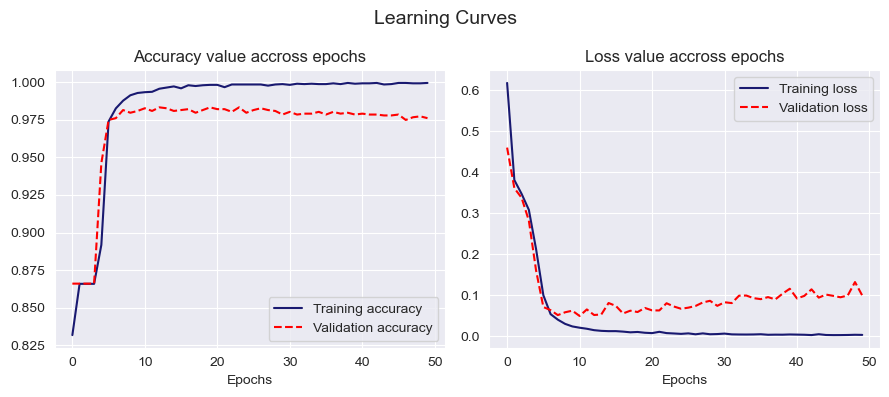

In [29]:
# Creation du diagramme à deux sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Tracé de la précision sur le premier sous-graphique
ax[0].plot(history.history["accuracy"], color="midnightblue", label="Précision d'entraînement")
ax[0].plot(history.history["val_accuracy"], color="r", ls='--', label="Précision de validation")
ax[0].set_title('Précision à travers les époques')
ax[0].legend()

# Tracé de la perte sur le deuxième sous-graphique
ax[1].plot(history.history["loss"], color="midnightblue", label="Perte d'entraînement")
ax[1].plot(history.history["val_loss"], ls='--', color="r", label="Perte de validation")
ax[1].set_title("Perte à travers les époques")
ax[1].legend()

# Étiquetage de l'axe des x
for ax in ax:
    ax.set(xlabel='Époques')

# Titre
fig.suptitle('Courbes d\'apprentissage', fontsize=14)

# Ajustement de la disposition et affichage du tracé
plt.tight_layout()
plt.show()

In [30]:
# Évaluation du modèle
val_loss, val_accuracy = model.evaluate(val_batch)
print(f"Perte de validation: {val_loss}")
print(f"Précision de validation: {val_accuracy}")

27/27 [==============================] - 0s 2ms/step - loss: 0.0996 - accuracy: 0.9761
Validation Loss: 0.09957955032587051
Validation Accuracy: 0.9760765433311462


Précision (Accuracy) : 0.976077. Cette valeur est très proche de 1, ce qui signifie que ce modèle a une précision élevée.

Perte (Loss) : 0.099580. Cette faible valeur indique que le nombre d'erreurs que fait le modèle est assez faible.

La précision de la validation reste plus ou moins stable après 10 epochs, mais la perte de validation semble augmenter légèrement.

En résumé, le "Simple Model" semble être un très bon modèle, car il a à la fois une précision élevée et une perte faible.

In [56]:
model.save("spam_detector_model.h5")

#### Modèle numéro 2 : LSTM

In [32]:
# Definition du model :
model_lstm = Sequential([
                  Embedding(vocab_size+1, embedding_dim, input_shape=[text.shape[1],], name="embedding"),
                  LSTM(units=64, return_sequences=True),
                  LSTM(units=32, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [33]:
# Compiler le modèle

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# Formation du modèle :
history_lstm=model_lstm.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 9s 74ms/step - loss: 0.4443 - accuracy: 0.8659 - val_loss: 0.3936 - val_accuracy: 0.8660
Epoch 2/50
61/61 [==============================] - 4s 59ms/step - loss: 0.3941 - accuracy: 0.8659 - val_loss: 0.3928 - val_accuracy: 0.8660
Epoch 3/50
61/61 [==============================] - 4s 59ms/step - loss: 0.3108 - accuracy: 0.8954 - val_loss: 0.1373 - val_accuracy: 0.9689
Epoch 4/50
61/61 [==============================] - 4s 59ms/step - loss: 0.1731 - accuracy: 0.9579 - val_loss: 0.2230 - val_accuracy: 0.9420
Epoch 5/50
61/61 [==============================] - 4s 58ms/step - loss: 0.2218 - accuracy: 0.9262 - val_loss: 0.2744 - val_accuracy: 0.7877
Epoch 6/50
61/61 [==============================] - 4s 58ms/step - loss: 0.2546 - accuracy: 0.8579 - val_loss: 0.2689 - val_accuracy: 0.8660
Epoch 7/50
61/61 [==============================] - 4s 58ms/step - loss: 0.2523 - accuracy: 0.8659 - val_loss: 0.2678 - val_accuracy: 0.8660
Epoch 8/50
61

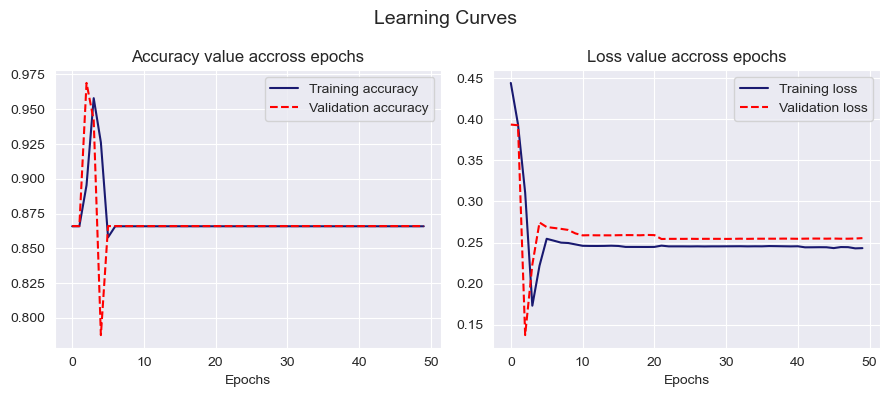

In [35]:
# Création du diagramme à deux sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Tracé de la précision sur le premier sous-graphique
ax[0].plot(history_lstm.history["accuracy"], color="midnightblue", label="Précision d'entraînement")
ax[0].plot(history_lstm.history["val_accuracy"], color="r", ls='--', label="Précision de validation")
ax[0].set_title('Précision à travers les époques')
ax[0].legend()

# Tracé de la perte sur le deuxième sous-graphique
ax[1].plot(history_lstm.history["loss"], color="midnightblue", label="Perte d'entraînement")
ax[1].plot(history_lstm.history["val_loss"], ls='--', color="r", label="Perte de validation")
ax[1].set_title("Perte à travers les époques")
ax[1].legend()

# Étiquetage de l'axe des x
for ax in ax:
    ax.set(xlabel='Époques')

# Titre global
fig.suptitle('Courbes d\'apprentissage', fontsize=14)

# Ajustement de la disposition et affichage du tracé
plt.tight_layout()
plt.show()

In [36]:
# Évaluation du modèle LSTM
val_loss_lstm, val_accuracy_lstm = model_lstm.evaluate(val_batch)
print(f"Perte de validation : {val_loss_lstm}")
print(f"Précision de validation : {val_accuracy_lstm}")

27/27 [==============================] - 1s 20ms/step - loss: 0.2554 - accuracy: 0.8660
Validation Loss: 0.2553880214691162
Validation Accuracy: 0.8660287261009216


Précision : 0.866029. Cette valeur est un peu plus faible que celle du "Simple Model", mais reste relativement élevée.

Perte : 0.255388. Cette valeur est significativement plus grande que celle du "Simple Model", indiquant que le "LSTM model" fait plus d'erreurs.

En résumé, bien que la précision soit légèrement plus faible et que la perte soit plus élevée, le modèle LSTM reste un modèle passablement bon.

In [37]:
model_lstm.save("spam_detector_model_lstm.h5")

#### 3eme modele : Simple RNN

In [38]:
# Définition du modèle :
model_rnn = Sequential([
    # Création d'une couche d'incorporation qui transforme chaque mot dans notre vocabulaire en un vecteur d'une certaine dimension
    Embedding(vocab_size + 1, embedding_dim, input_shape=[text.shape[1], ], name="embedding"),

    # Première couche RNN avec 16 unités. Le paramètre return_sequences spécifie si la couche doit renvoyer la séquence complète ou seulement la dernière sortie.
    SimpleRNN(units=16, return_sequences=True),

    # Deuxième couche RNN avec 8 unités. Cette fois, nous ne retournons que la dernière sortie.
    SimpleRNN(units=8, return_sequences=False),

    # Une couche dense (aussi appelée "complètement connectée") avec 16 unités et une fonction d'activation ReLU.
    Dense(16, activation='relu'),

    # La dernière couche dense avec une seule unité et une fonction d'activation sigmoid. Elle renvoie la probabilité que le texte entrant appartienne à une certaine catégorie.
    Dense(1, activation="sigmoid")
]);

In [39]:
# Compilation
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
# Entrainement
history_rnn=model_rnn.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 4s 30ms/step - loss: 0.3305 - accuracy: 0.8946 - val_loss: 0.3099 - val_accuracy: 0.8774
Epoch 2/50
61/61 [==============================] - 1s 24ms/step - loss: 0.1690 - accuracy: 0.9577 - val_loss: 0.1933 - val_accuracy: 0.9390
Epoch 3/50
61/61 [==============================] - 1s 24ms/step - loss: 0.1050 - accuracy: 0.9741 - val_loss: 0.1714 - val_accuracy: 0.9504
Epoch 4/50
61/61 [==============================] - 1s 24ms/step - loss: 0.0607 - accuracy: 0.9872 - val_loss: 0.1683 - val_accuracy: 0.9510
Epoch 5/50
61/61 [==============================] - 1s 24ms/step - loss: 0.0358 - accuracy: 0.9941 - val_loss: 0.1713 - val_accuracy: 0.9516
Epoch 6/50
61/61 [==============================] - 1s 24ms/step - loss: 0.0295 - accuracy: 0.9936 - val_loss: 0.1895 - val_accuracy: 0.9522
Epoch 7/50
61/61 [==============================] - 2s 25ms/step - loss: 0.0385 - accuracy: 0.9905 - val_loss: 0.1906 - val_accuracy: 0.9528
Epoch 8/50
61

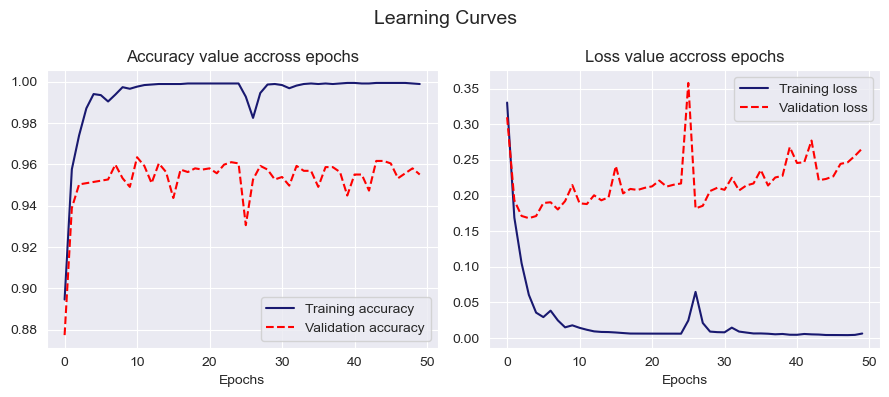

In [41]:
# Création du diagramme à deux sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Traçage de la précision sur le premier sous-graphique
ax[0].plot(history_rnn.history["accuracy"], color="midnightblue", label="Précision d'entraînement")
ax[0].plot(history_rnn.history["val_accuracy"], color="r", ls='--', label="Précision de validation")
ax[0].set_title('Précision à travers les époques')
ax[0].legend()

# Traçage de la perte sur le deuxième sous-graphique
ax[1].plot(history_rnn.history["loss"], color="midnightblue", label="Perte d'entraînement")
ax[1].plot(history_rnn.history["val_loss"], ls='--', color="r", label="Perte de validation")
ax[1].set_title("Perte à travers les époques")
ax[1].legend()

# Étiquetage de l'axe des x
for ax in ax:
    ax.set(xlabel='Époques')

# Titre global
fig.suptitle('Courbes d\'apprentissage', fontsize=14)

# Ajustement de la disposition et affichage du tracé
plt.tight_layout()
plt.show()

In [42]:
# Evaluation
val_loss_rnn, val_accuracy_rnn = model_rnn.evaluate(val_batch)
print(f"Validation Loss: {val_loss_rnn}")
print(f"Validation Accuracy: {val_accuracy_rnn}")

27/27 [==============================] - 0s 6ms/step - loss: 0.2663 - accuracy: 0.9551
Validation Loss: 0.2662677466869354
Validation Accuracy: 0.9551435112953186


Précision : 0.955144. Cette valeur est plus élevée que celle du modèle LSTM, mais reste plus faible que celle du "Simple Model".

Perte : 0.266268. Cette valeur est la plus élevée jusqu'à maintenant, indiquant que ce modèle a une erreur plus importante.

La précision de la validation est assez bonne et stable, et la perte de validation n'augmente pas beaucoup après 10/15 epochs.

En résumé, le "Simple RNN model" semble être un modèle intermédiaire : il a une précision élevée mais aussi une perte élevée.

In [43]:
model_rnn.save("spam_detector_model_rnn.h5")

#### 4ème modèle : GRU :

In [44]:
# Definition du modèle
model_gru = Sequential([
                  Embedding(vocab_size+1, embedding_dim, input_shape=[text.shape[1],], name="embedding"),
                  GRU(units=64, return_sequences=True),
                  GRU(units=32, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [45]:
# Compilation
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
# Entrainement
history_gru=model_gru.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 8s 62ms/step - loss: 0.4609 - accuracy: 0.8659 - val_loss: 0.3941 - val_accuracy: 0.8660
Epoch 2/50
61/61 [==============================] - 3s 48ms/step - loss: 0.3949 - accuracy: 0.8659 - val_loss: 0.3939 - val_accuracy: 0.8660
Epoch 3/50
61/61 [==============================] - 3s 49ms/step - loss: 0.3966 - accuracy: 0.8659 - val_loss: 0.3942 - val_accuracy: 0.8660
Epoch 4/50
61/61 [==============================] - 3s 52ms/step - loss: 0.3942 - accuracy: 0.8659 - val_loss: 0.3941 - val_accuracy: 0.8660
Epoch 5/50
61/61 [==============================] - 3s 48ms/step - loss: 0.3949 - accuracy: 0.8659 - val_loss: 0.3939 - val_accuracy: 0.8660
Epoch 6/50
61/61 [==============================] - 3s 48ms/step - loss: 0.3955 - accuracy: 0.8659 - val_loss: 0.3970 - val_accuracy: 0.8660
Epoch 7/50
61/61 [==============================] - 3s 50ms/step - loss: 0.3946 - accuracy: 0.8659 - val_loss: 0.3939 - val_accuracy: 0.8660
Epoch 8/50
61

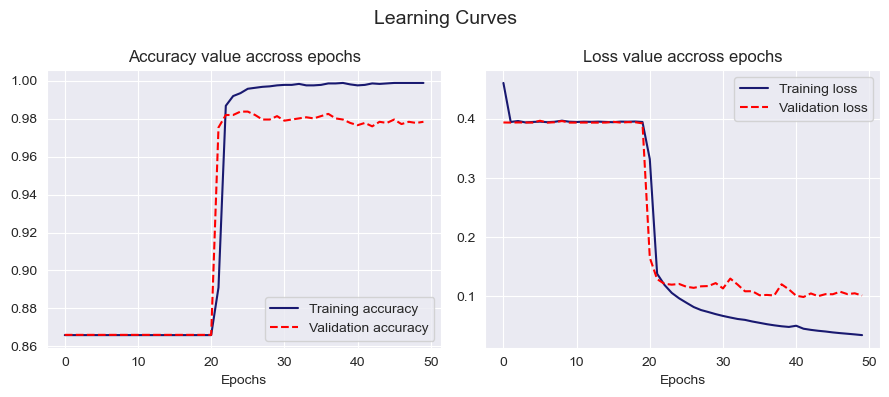

In [47]:
# Création du diagramme à deux sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Traçage de la précision sur le premier sous-graphique
ax[0].plot(history_rnn.history["accuracy"], color="midnightblue", label="Précision d'entraînement")
ax[0].plot(history_rnn.history["val_accuracy"], color="r", ls='--', label="Précision de validation")
ax[0].set_title('Précision à travers les époques')
ax[0].legend()

# Traçage de la perte sur le deuxième sous-graphique
ax[1].plot(history_rnn.history["loss"], color="midnightblue", label="Perte d'entraînement")
ax[1].plot(history_rnn.history["val_loss"], ls='--', color="r", label="Perte de validation")
ax[1].set_title("Perte à travers les époques")
ax[1].legend()

# Étiquetage de l'axe des x
for ax in ax:
    ax.set(xlabel='Époques')

# Titre
fig.suptitle('Courbes d\'apprentissage', fontsize=14)

# Ajustement de la disposition et affichage du tracé
plt.tight_layout()
plt.show()

In [48]:
# Evaluation
val_loss_gru, val_accuracy_gru = model_gru.evaluate(val_batch)
print(f"Validation Loss: {val_loss_gru}")
print(f"Validation Accuracy: {val_accuracy_gru}")

27/27 [==============================] - 0s 15ms/step - loss: 0.1015 - accuracy: 0.9785
Validation Loss: 0.10148219019174576
Validation Accuracy: 0.9784688949584961


Précision : 0.978469. Cette valeur est la plus élevée de tous les modèles jusqu'à maintenant, ce qui indique une excellente performance en termes de précision.

Perte : 0.101482. Cette valeur est assez faible, très proche de celle du "Simple Model".

En résumé, le "GRU model" semble être le meilleur modèle jusqu'à maintenant, ayant la précision la plus élevée et une perte faible. Un champion ?

In [49]:
model_gru.save("spam_detector_model_gru.h5")

#### Transfer learning :

In [50]:
# Division du jeu de données en jeux d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(df['text_clean'], df['Target_value'], test_size=0.3)

# Conversion des ensembles d'entraînement et de validation en objets tensorflow Dataset
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Mélange et mise en lot des données d'entraînement et de validation avec une taille de lot de 64
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [51]:
# Importation des bibliothèques
import tensorflow_hub as hub
import tensorflow_text

# Création d'une entrée de modèle
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

# Application du prétraitement BERT
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)

# Application de l'encodage BERT
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-2-h-128-a-2/versions/2",
    trainable=False)
outputs = encoder(encoder_inputs)

# Extraction des sorties pertinentes de BERT
pooled_output = outputs["pooled_output"]  # [batch_size, 768]
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768]

# Ajout de couches supplémentaires au modèle
out = tf.keras.layers.Dropout(0.2, name='dropout')(pooled_output)
out = tf.keras.layers.Dense(16, activation='relu')(out)
out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(out)

# Construction du modèle
model_bert = tf.keras.Model(inputs=[text_input], outputs=[out])

# Compilation du modèle
model_bert.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history_bert = model_bert.fit(train_batch,
                              epochs=50,
                              validation_data=val_batch)

INFO:absl:Using /var/folders/gh/5x8myy1s5j577m7hgyjfy8800000gn/T/tfhub_modules to cache modules.
INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.
INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.


Epoch 1/50
61/61 [==============================] - 25s 362ms/step - loss: 0.3278 - accuracy: 0.8672 - val_loss: 0.2034 - val_accuracy: 0.9181
Epoch 2/50
61/61 [==============================] - 23s 373ms/step - loss: 0.1988 - accuracy: 0.9192 - val_loss: 0.1573 - val_accuracy: 0.9408
Epoch 3/50
61/61 [==============================] - 26s 435ms/step - loss: 0.1583 - accuracy: 0.9405 - val_loss: 0.1372 - val_accuracy: 0.9504
Epoch 4/50
61/61 [==============================] - 23s 382ms/step - loss: 0.1487 - accuracy: 0.9418 - val_loss: 0.1291 - val_accuracy: 0.9575
Epoch 5/50
61/61 [==============================] - 24s 398ms/step - loss: 0.1367 - accuracy: 0.9482 - val_loss: 0.1231 - val_accuracy: 0.9581
Epoch 6/50
61/61 [==============================] - 24s 398ms/step - loss: 0.1377 - accuracy: 0.9472 - val_loss: 0.1180 - val_accuracy: 0.9593
Epoch 7/50
61/61 [==============================] - 23s 380ms/step - loss: 0.1277 - accuracy: 0.9533 - val_loss: 0.1147 - val_accuracy: 0.9581

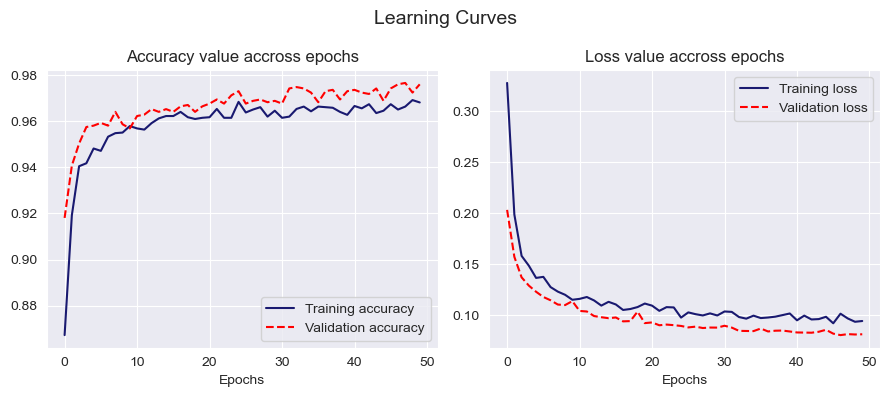

In [52]:
# Création de la figure avec deux sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Tracé de la précision plein entrainement et de validation sur le premier sous-graphique
ax[0].plot(history_bert.history["accuracy"], color="midnightblue", label="Précision de l'entraînement")
ax[0].plot(history_bert.history["val_accuracy"], color="r", ls='--', label="Précision de validation")
ax[0].set_title('Précision à travers les époques')
ax[0].legend()

# Tracé des pertes d'entraînement et de validation sur le second sous-graphique
ax[1].plot(history_bert.history["loss"], color="midnightblue", label="Perte d'apprentissage")
ax[1].plot(history_bert.history["val_loss"], ls='--', color="r", label="Perte de validation")
ax[1].set_title("Perte à travers les époques")
ax[1].legend()

# Étiquetage de l'axe x pour les deux sous-graphiques
for ax in ax:
    ax.set(xlabel='Époques')

# Création du titre global de la figure
fig.suptitle('Courbes d\'apprentissage', fontsize=14)

# Ajustement de la disposition et affichage du graphique
plt.tight_layout()
plt.show()

In [53]:
# Evaluation du modèle

val_loss_bert, val_accuracy_bert = model_bert.evaluate(val_batch)
print(f"Validation Loss: {val_loss_bert}")
print(f"Validation Accuracy: {val_accuracy_bert}")

27/27 [==============================] - 7s 254ms/step - loss: 0.0814 - accuracy: 0.9761
Validation Loss: 0.0814257264137268
Validation Accuracy: 0.9760765433311462


Précision : 0.976077. Cette valeur est très élevée, à égalité avec le "Simple Model".

Perte : 0.081426. C'est la valeur la plus faible de tous les modèles, ce qui indique que le modèle BERT fait le moins d'erreurs.

En résumé, le "Bert model" semble très performant.

La précision de validation atteint 0,97 et reste stable après 20 époques et la perte de validation reste stable à 0,1 après 20 époques et ne semble pas augmenter.

In [54]:
model_bert.save("spam_detector_model_bert.h5")

In [55]:
# Création d'un DataFrame avec les résultats
results = pd.DataFrame({'Modèle Simple': [val_accuracy, val_loss],
                        'Modèle LSTM': [val_accuracy_lstm, val_loss_lstm],
                        'Modèle RNN Simple': [val_accuracy_rnn, val_loss_rnn],
                        'Modèle GRU': [val_accuracy_gru, val_loss_gru],
                        'Modèle Bert': [val_accuracy_bert, val_loss_bert]},
                       index=['Précision', 'Perte'])

# Affichage du DataFrame transposé
results.T

,Accuracy,Loss
Simple Model,0.976077,0.099580
LSTM model,0.866029,0.255388
Simple RNN model,0.955144,0.266268
GRU model,0.978469,0.101482
Bert model,0.976077,0.081426


# Conclusions :

* Ainsi, avec ce nouvel ensemble de données, il semble pour moi que le "GRU model" et le "Bert model" sont les modèles les plus performants parmi ceux que j'ai présentés, le "Bert model" ayant la plus faible perte et le "GRU model" la plus haute précision

* Nous avons également obtenu de bons résultats avec le modèle BERT, ce qui est assez logique puisque le modèle a été pré-entraîné plusieurs fois auparavant et que ce modèle nous permet d'éviter le nettoyage de texte, mais le temps de calcul a été assez long pour celui-ci.

* Nous pouvons également essayer de modifier « maxwords » et « maxlen » pour améliorer les résultats et le temps de calcul.